<a href="https://colab.research.google.com/github/Taniyasumbul/my_project/blob/main/Copy_of_notebook442c76060a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install xgboost lightgbm catboost optuna scikit-learn pandas numpy matplotlib seaborn plotly -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 22.4 MB/s eta 0:00:00


In [124]:

# ============================================================================
# 2025 Kaggle Playground Series - Road Accident Prediction
# Complete End-to-End Solution
# Goal: Predict likelihood of accidents on different types of roads
# ============================================================================

# ============================================================================
# SECTION 1: ENVIRONMENT SETUP
# ============================================================================

# Install required packages


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (roc_auc_score, log_loss, accuracy_score, classification_report,
                             confusion_matrix, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Set style and random seed
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("=" * 70)
print("2025 KAGGLE PLAYGROUND SERIES - ROAD ACCIDENT PREDICTION")
print("=" * 70)

2025 KAGGLE PLAYGROUND SERIES - ROAD ACCIDENT PREDICTION


In [85]:
from google.colab import files
print("\n📁 Please upload your kaggle.json file:")
uploaded = files.upload()

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✓ Kaggle API configured successfully!")

# Download competition data
# Note: Replace with the actual competition name once announced
COMPETITION_NAME = 'playground-series-s5e10'  # Update this!

print(f"\n[STEP 2] Downloading competition data: {COMPETITION_NAME}")
!kaggle competitions download -c {



📁 Please upload your kaggle.json file:


KeyboardInterrupt: 

In [86]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [87]:
train.shape

(115673, 14)

In [88]:
test.shape

(137612, 13)

In [90]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35.0,daylight,rainy,False,True,afternoon,False,True,1.0,0.13
1,1,urban,4,0.99,35.0,daylight,clear,True,False,evening,True,True,0.0,0.35
2,2,rural,4,0.63,70.0,dim,clear,False,True,morning,True,False,2.0,0.30
3,3,highway,4,0.07,35.0,dim,rainy,True,True,morning,False,False,1.0,0.21
4,4,rural,1,0.58,60.0,daylight,foggy,False,False,evening,True,False,1.0,0.56


In [91]:
print("\n❓ Missing values:")
missing = train.isnull().sum()
if missing.sum() > 0:
    display(missing[missing > 0])
else:
    print("No missing values found!")


❓ Missing values:


,0
speed_limit,1
lighting,1
weather,1
road_signs_present,1
public_road,1
time_of_day,1
holiday,1
school_season,1
num_reported_accidents,1
accident_risk,1


In [92]:

target_col = sample_submission.columns[-1]

In [93]:
target_dist = train[target_col].value_counts()
display(target_dist)
print(f"Class balance: {target_dist.values[1]/target_dist.values[0]*100:.2f}% positive class")


,count
accident_risk,
0.34,3435
0.32,3113
0.28,2980
0.37,2928
0.36,2771
...,...
0.94,8
0.97,7
0.93,7


Class balance: 90.63% positive class


In [94]:
id_col = 'id' if 'id' in train.columns else None
feature_cols = [col for col in train.columns if col not in [target_col, id_col]]
numeric_cols = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature breakdown:")
print(f"  • Total features: {len(feature_cols)}")
print(f"  • Numeric features: {len(numeric_cols)}")
print(f"  • Categorical features: {len(categorical_cols)}")

# Statistical summary
print("\n📊 Statistical Summary (Numeric Features):")
display(train[numeric_cols].describe())


Feature breakdown:
  • Total features: 12
  • Numeric features: 4
  • Categorical features: 8

📊 Statistical Summary (Numeric Features):


,num_lanes,curvature,speed_limit,num_reported_accidents
count,115673.000000,115673.000000,115672.000000,115672.000000
mean,2.491359,0.487761,46.109344,1.189147
std,1.119331,0.272449,15.813630,0.896608
min,1.000000,0.000000,25.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000
50%,2.000000,0.510000,45.000000,1.000000
75%,3.000000,0.710000,60.000000,2.000000
max,4.000000,1.000000,70.000000,7.000000


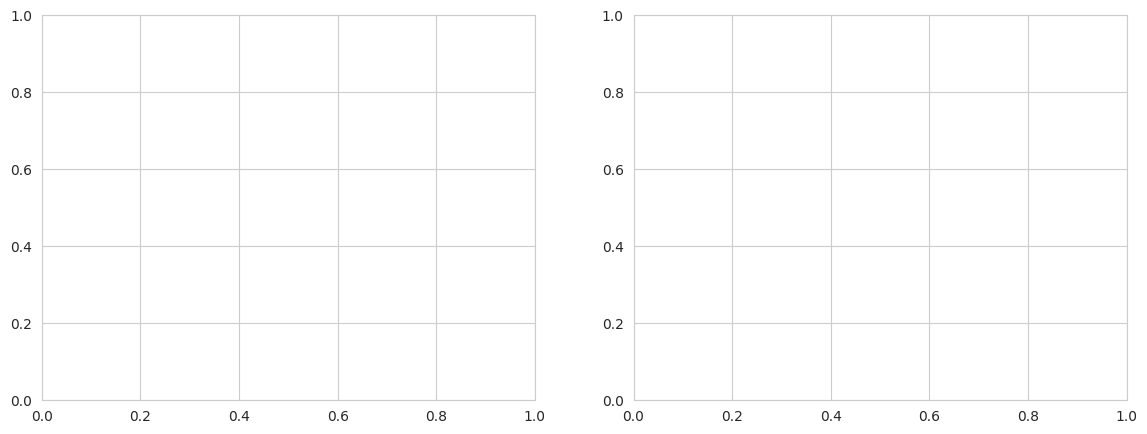

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

In [96]:
train[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)


In [97]:
target_pct = train[target_col].value_counts(normalize=True) * 100
target_pct.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Target Distribution (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel(target_col)
axes[1].set_ylabel('Percentage')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>


🔗 Feature Correlations:


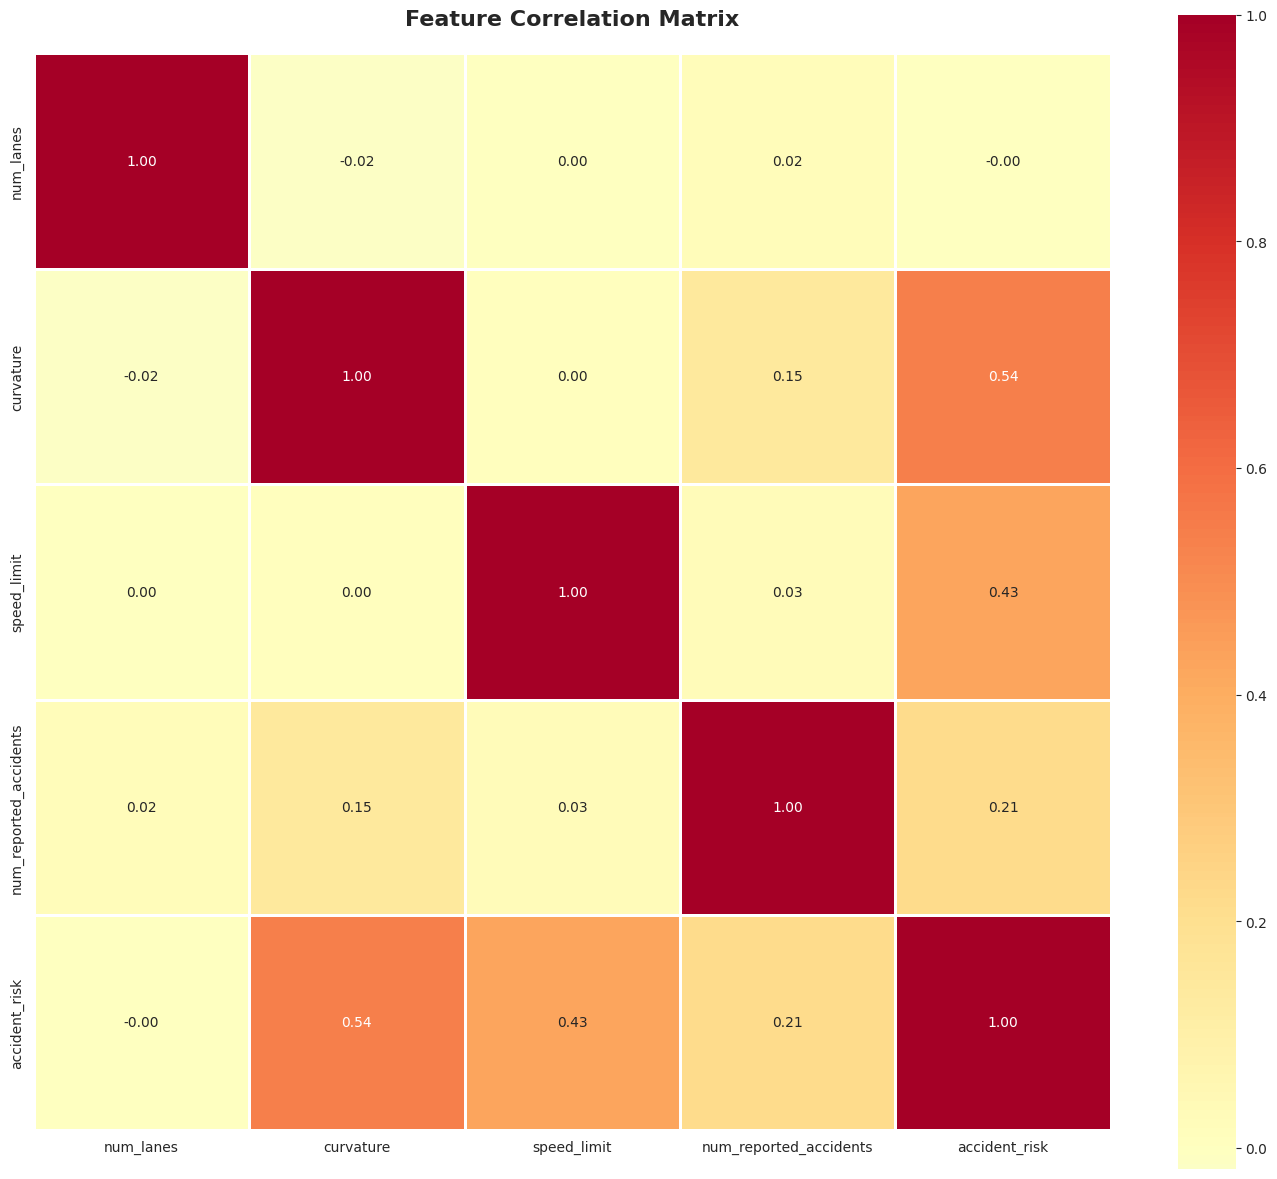


🎯 Top 10 features correlated with target:


,accident_risk
curvature,0.544266
speed_limit,0.428891
num_reported_accidents,0.212306
num_lanes,0.003657


In [98]:
if len(numeric_cols) > 0:
    print("\n🔗 Feature Correlations:")
    correlation_matrix = train[numeric_cols + [target_col]].corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
                center=0, square=True, linewidths=1)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Top correlations with target
    target_corr = correlation_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
    print(f"\n🎯 Top 10 features correlated with target:")
    display(target_corr.head(10))

In [99]:
if len(categorical_cols) > 0:
    print(f"\n📋 Categorical Features Analysis:")
    for col in categorical_cols[:5]:  # Show first 5
        print(f"\n{col}: {train[col].nunique()} unique values")
        display(train[col].value_counts().head())



📋 Categorical Features Analysis:

road_type: 3 unique values


,count
road_type,
highway,38691
rural,38524
urban,38458



lighting: 3 unique values


,count
lighting,
dim,41164
daylight,39922
night,34586



weather: 3 unique values


,count
weather,
foggy,40649
clear,40210
rainy,34813



road_signs_present: 2 unique values


,count
road_signs_present,
True,57955
False,57717



public_road: 2 unique values


,count
public_road,
True,58291
False,57381


In [100]:
print("\n[STEP 5] Engineering features...")

def engineer_features(df, is_train=True):
    """
    Advanced feature engineering for road accident prediction
    """
    df = df.copy()

    # Get numeric and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Remove ID and target from numeric columns
    if id_col and id_col in num_cols:
        num_cols.remove(id_col)
    if is_train and target_col in num_cols:
        num_cols.remove(target_col)

    # 1. Polynomial Features
    if len(num_cols) >= 2:
        df[f'{num_cols[0]}_squared'] = df[num_cols[0]] ** 2
        df[f'{num_cols[1]}_squared'] = df[num_cols[1]] ** 2
        df[f'{num_cols[0]}_x_{num_cols[1]}'] = df[num_cols[0]] * df[num_cols[1]]

    # 2. Statistical aggregations
    if len(num_cols) >= 3:
        df['numeric_mean'] = df[num_cols].mean(axis=1)
        df['numeric_std'] = df[num_cols].std(axis=1)
        df['numeric_max'] = df[num_cols].max(axis=1)
        df['numeric_min'] = df[num_cols].min(axis=1)
        df['numeric_range'] = df['numeric_max'] - df['numeric_min']
        df['numeric_median'] = df[num_cols].median(axis=1)
        df['numeric_skew'] = df[num_cols].skew(axis=1)

    # 3. Ratio features
    if len(num_cols) >= 2:
        for i in range(min(2, len(num_cols)-1)):
            for j in range(i+1, min(3, len(num_cols))):
                col1, col2 = num_cols[i], num_cols[j]
                df[f'{col1}_div_{col2}'] = df[col1] / (df[col2] + 1e-5)
                df[f'{col1}_plus_{col2}'] = df[col1] + df[col2]

    # 4. Log transformations (for skewed features)
    for col in num_cols[:5]:  # Apply to first 5 numeric features
        if (df[col] > 0).all():
            df[f'{col}_log'] = np.log1p(df[col])

    # 5. Binning continuous features
    for col in num_cols[:3]:
        df[f'{col}_bin'] = pd.qcut(df[col], q=5, labels=False, duplicates='drop')

    return df


[STEP 5] Engineering features...


In [102]:
print("Generating features for training data...")
train_fe = engineer_features(train, is_train=True)
print("Generating features for test data...")
test_fe = engineer_features(test, is_train=False)

print(f"\n✓ Feature engineering complete!")
print(f"  Original features: {train.shape[1]}")
print(f"  Enhanced features: {train_fe.shape[1]}")
print(f"  New features created: {train_fe.shape[1] - train.shape[1]}")


Generating features for training data...
Generating features for test data...

✓ Feature engineering complete!
  Original features: 14
  Enhanced features: 34
  New features created: 20


In [116]:
# Alternative: More robust preprocessing function
def preprocess_data(train_df, test_df, target_col, id_col=None):
    """Comprehensive data preprocessing with unseen value handling"""

    # Store IDs
    if id_col and id_col in train_df.columns:
        train_ids = train_df[id_col]
        test_ids = test_df[id_col]
        train_df = train_df.drop(id_col, axis=1)
        test_df = test_df.drop(id_col, axis=1)
    else:
        train_ids = None
        test_ids = test_df.index if id_col is None else None

    # Separate features and target
    X = train_df.drop(target_col, axis=1)
    y = train_df[target_col]
    X_test = test_df.copy()

    # Align columns
    X_test = X_test[X.columns]

    # Handle categorical features with unseen values
    cat_features = X.select_dtypes(include=['object']).columns.tolist()
    label_encoders = {}

    for col in cat_features:
        # Combine train and test for consistent encoding
        combined = pd.concat([X[col].astype(str), X_test[col].astype(str)], axis=0)

        le = LabelEncoder()
        le.fit(combined)

        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

        print(f"  ✓ Encoded '{col}': {len(le.classes_)} unique values")

    # Handle missing values
    if X.isnull().sum().sum() > 0:
        X = X.fillna(X.median())
    if X_test.isnull().sum().sum() > 0:
        X_test = X_test.fillna(X_test.median())

    # Handle infinite values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

    print(f"\n  • Features shape: {X.shape}")
    print(f"  • Target shape: {y.shape}")
    print(f"  • Test shape: {X_test.shape}")
    print(f"  • Categorical features encoded: {len(cat_features)}")

    return X, y, X_test, train_ids, test_ids

# Rerun preprocessing
X, y, X_test, train_ids, test_ids = preprocess_data(train_fe, test_fe, target_col, id_col)


  ✓ Encoded 'road_type': 3 unique values
  ✓ Encoded 'lighting': 5 unique values
  ✓ Encoded 'weather': 4 unique values
  ✓ Encoded 'road_signs_present': 3 unique values
  ✓ Encoded 'public_road': 3 unique values
  ✓ Encoded 'time_of_day': 4 unique values
  ✓ Encoded 'holiday': 3 unique values
  ✓ Encoded 'school_season': 3 unique values

  • Features shape: (115673, 32)
  • Target shape: (115673,)
  • Test shape: (137612, 32)
  • Categorical features encoded: 8


In [118]:
# Check and clean the data before splitting
print(f"Checking for NaN values...")
print(f"  • NaN in X: {X.isnull().sum().sum()}")
print(f"  • NaN in y: {y.isnull().sum()}")

# Remove rows with NaN in target
if y.isnull().sum() > 0:
    print(f"\n⚠ Removing {y.isnull().sum()} rows with missing target values...")
    valid_mask = ~y.isnull()
    X = X[valid_mask].reset_index(drop=True)
    y = y[valid_mask].reset_index(drop=True)
    print(f"✓ Cleaned data: X shape = {X.shape}, y shape = {y.shape}")

# Now split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\nData split:")
print(f"  • Training: {X_train.shape[0]} samples")
print(f"  • Validation: {X_val.shape[0]} samples")

Checking for NaN values...
  • NaN in X: 0
  • NaN in y: 1

⚠ Removing 1 rows with missing target values...
✓ Cleaned data: X shape = (115672, 32), y shape = (115672,)

Data split:
  • Training: 92537 samples
  • Validation: 23135 samples


In [125]:
model_results = {}


# --- MODEL 2: LightGBM ---
print("\n" + "="*70)
print("🚀 TRAINING LIGHTGBM REGRESSOR")
print("="*70)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': RANDOM_SEED,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
)

lgb_val_pred = lgb_model.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_pred))
lgb_mae = mean_absolute_error(y_val, lgb_val_pred)
lgb_r2 = r2_score(y_val, lgb_val_pred)
model_results['LightGBM'] = {'RMSE': lgb_rmse, 'MAE': lgb_mae, 'R2': lgb_r2}
print(f"\n✓ LightGBM Validation Metrics:")
print(f"  RMSE: {lgb_rmse:.6f}")
print(f"  MAE: {lgb_mae:.6f}")
print(f"  R2: {lgb_r2:.6f}")

# --- MODEL 3: CatBoost ---
print("\n" + "="*70)
print("🚀 TRAINING CATBOOST REGRESSOR")
print("="*70)

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 7,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': RANDOM_SEED,
    'early_stopping_rounds': 50,
    'verbose': 100
}

cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

cat_val_pred = cat_model.predict(X_val)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_val_pred))
cat_mae = mean_absolute_error(y_val, cat_val_pred)
cat_r2 = r2_score(y_val, cat_val_pred)
model_results['CatBoost'] = {'RMSE': cat_rmse, 'MAE': cat_mae, 'R2': cat_r2}
print(f"\n✓ CatBoost Validation Metrics:")
print(f"  RMSE: {cat_rmse:.6f}")
print(f"  MAE: {cat_mae:.6f}")
print(f"  R2: {cat_r2:.6f}")


🚀 TRAINING LIGHTGBM REGRESSOR
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.0580898
[200]	valid_0's rmse: 0.0566867
[300]	valid_0's rmse: 0.0566541
Early stopping, best iteration is:
[327]	valid_0's rmse: 0.0566405

✓ LightGBM Validation Metrics:
  RMSE: 0.056641
  MAE: 0.043997
  R2: 0.884051

🚀 TRAINING CATBOOST REGRESSOR
0:	learn: 0.1621999	test: 0.1620791	best: 0.1620791 (0)	total: 80.7ms	remaining: 1m 20s
100:	learn: 0.0575387	test: 0.0577057	best: 0.0577057 (100)	total: 4.04s	remaining: 35.9s
200:	learn: 0.0565407	test: 0.0569367	best: 0.0569367 (200)	total: 7.22s	remaining: 28.7s
300:	learn: 0.0563244	test: 0.0568642	best: 0.0568642 (300)	total: 10.3s	remaining: 23.9s
400:	learn: 0.0561386	test: 0.0568241	best: 0.0568241 (400)	total: 13s	remaining: 19.3s
500:	learn: 0.0559536	test: 0.0567935	best: 0.0567933 (499)	total: 16.6s	remaining: 16.5s
600:	learn: 0.0557740	test: 0.0567725	best: 0.0567722 (599)	total: 19.8s	remaining: 13.2s
700:	lea

In [126]:
ensemble_val_pred = ( lgb_val_pred + cat_val_pred) / 3
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred))
ensemble_mae = mean_absolute_error(y_val, ensemble_val_pred)
ensemble_r2 = r2_score(y_val, ensemble_val_pred)
model_results['Ensemble (Average)'] = {'RMSE': ensemble_rmse, 'MAE': ensemble_mae, 'R2': ensemble_r2}

In [127]:
total_r2 =  + lgb_r2 + cat_r2

w_lgb = lgb_r2 / total_r2 if total_r2 > 0 else 1/3
w_cat = cat_r2 / total_r2 if total_r2 > 0 else 1/3

weighted_ensemble_pred = (
                          w_lgb * lgb_val_pred +
                          w_cat * cat_val_pred)
weighted_rmse = np.sqrt(mean_squared_error(y_val, weighted_ensemble_pred))
weighted_mae = mean_absolute_error(y_val, weighted_ensemble_pred)
weighted_r2 = r2_score(y_val, weighted_ensemble_pred)
model_results['Ensemble (Weighted)'] = {'RMSE': weighted_rmse, 'MAE': weighted_mae, 'R2': weighted_r2}

print(f"\nEnsemble weights:LGB={w_lgb:.3f}, CAT={w_cat:.3f}")



Ensemble weights:LGB=0.500, CAT=0.500


In [129]:

print("📊 MODEL PERFORMANCE COMPARISON")
print("="*70)
results_list = []
for model_name, metrics in model_results.items():
    results_list.append({
        'Model': model_name,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R2': metrics['R2']
    })
results_df = pd.DataFrame(results_list).sort_values('RMSE')
display(results_df)

📊 MODEL PERFORMANCE COMPARISON


,Model,RMSE,MAE,R2
0,LightGBM,0.056641,0.043997,0.884051
3,Ensemble (Weighted),0.056643,0.044021,0.884040
1,CatBoost,0.056752,0.044130,0.883595
2,Ensemble (Average),0.140009,0.120189,0.291522


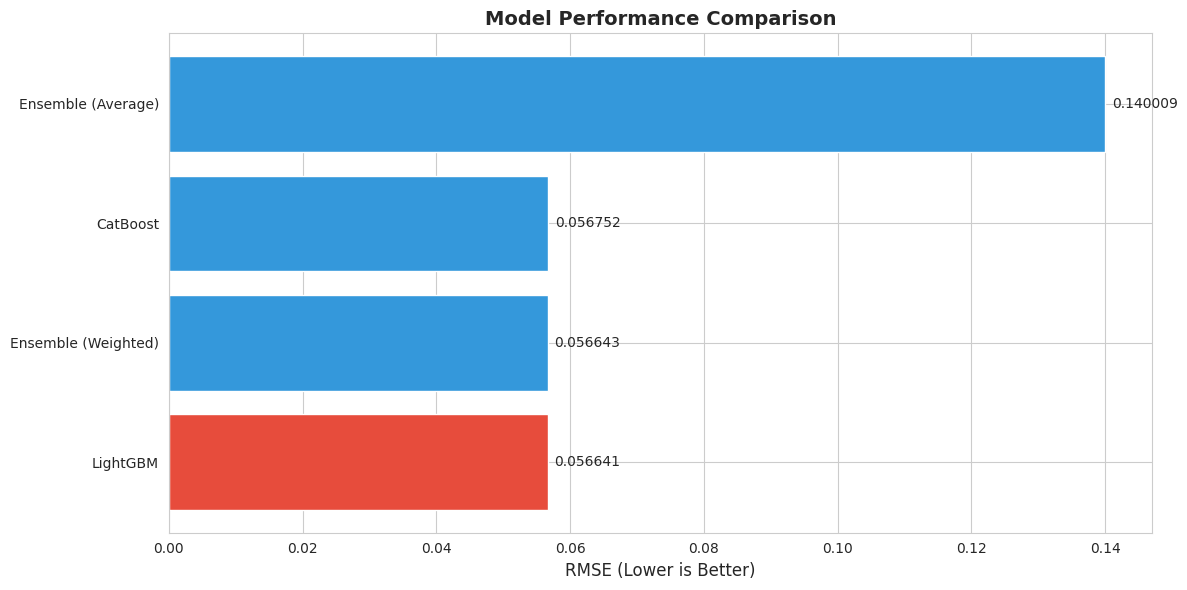

In [130]:
plt.figure(figsize=(12, 6))
plt.barh(results_df['Model'], results_df['RMSE'],
         color=['#e74c3c' if i == 0 else '#3498db' for i in range(len(results_df))])
plt.xlabel('RMSE (Lower is Better)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
for i, (model, rmse) in enumerate(zip(results_df['Model'], results_df['RMSE'])):
    plt.text(rmse + 0.001, i, f'{rmse:.6f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()


Top 20 Most Important Features:


,feature,importance
2,curvature,1706
5,weather,933
27,curvature_plus_speed_limit,736
11,num_reported_accidents,701
26,curvature_div_speed_limit,663
21,numeric_skew,510
14,num_lanes_x_curvature,508
22,num_lanes_div_curvature,454
16,numeric_std,451
15,numeric_mean,407


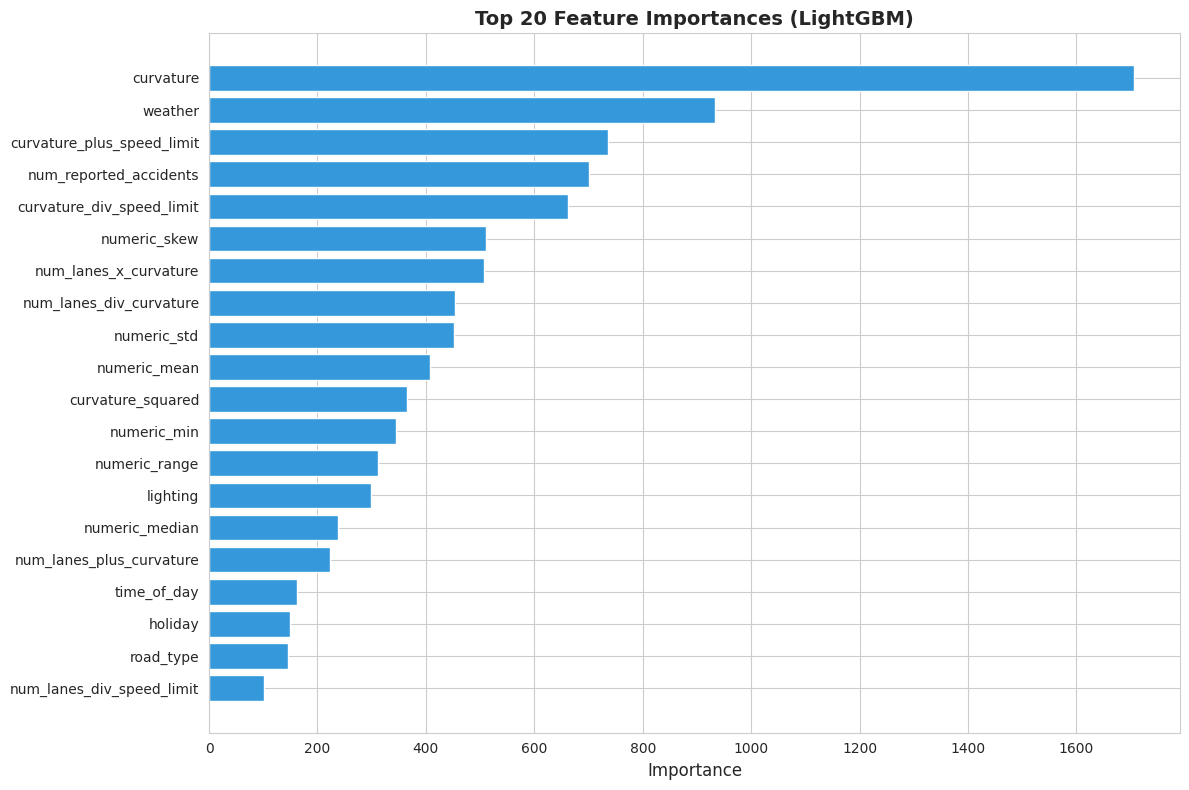

In [132]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
display(feature_importance.head(20))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='#3498db')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importances (LightGBM)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [135]:



# Retrain models on full training data
print("\nRetraining on full training data...")


lgb_model_full = lgb.LGBMRegressor(**{k: v for k, v in lgb_params.items() if k != 'early_stopping_rounds'})
lgb_model_full.set_params(n_estimators=lgb_model.best_iteration_)
lgb_model_full.fit(X, y)

cat_model_full = CatBoostRegressor(**{k: v for k, v in cat_params.items() if k != 'early_stopping_rounds'})
cat_model_full.set_params(iterations=cat_model.best_iteration_)
cat_model_full.fit(X, y, verbose=False)

# Generate predictions
print("Generating predictions on test set...")

lgb_test_pred = lgb_model_full.predict(X_test)
cat_test_pred = cat_model_full.predict(X_test)

# Use weighted ensemble (best performing method)
final_predictions = (
                     w_lgb * lgb_test_pred +
                     w_cat * cat_test_pred)

print(f"\n✓ Predictions generated!")
print(f"  • Min: {final_predictions.min():.6f}")
print(f"  • Max: {final_predictions.max():.6f}")
print(f"  • Mean: {final_predictions.mean():.6f}")
print(f"  • Median: {np.median(final_predictions):.6f}")



Retraining on full training data...
Generating predictions on test set...

✓ Predictions generated!
  • Min: 0.016646
  • Max: 0.869504
  • Mean: 0.351561
  • Median: 0.337919


In [142]:
# EMERGENCY NULL FIX - Run this before saving submission
print("🔧 Emergency null value fix...")

# Check for nulls
null_count = submission[target_col].isnull().sum()
print(f"Found {null_count} null values")

if null_count > 0:
    # Strategy 1: Fill with median of non-null predictions
    median_value = submission[target_col].median()

    if pd.isna(median_value):
        # Strategy 2: Fill with mean of training target
        median_value = y.mean()
        print(f"Using training target mean: {median_value:.6f}")
    else:
        print(f"Using prediction median: {median_value:.6f}")

    # Fill null values
    submission[target_col].fillna(median_value, inplace=True)

    # Double check
    remaining_nulls = submission[target_col].isnull().sum()

    if remaining_nulls > 0:
        # Strategy 3: Fill with zero or a safe default
        print(f"⚠ Still {remaining_nulls} nulls, using 0 as fallback")
        submission[target_col].fillna(0, inplace=True)

# Check for infinite values
inf_count = np.isinf(submission[target_col]).sum()
print(f"Found {inf_count} infinite values")

if inf_count > 0:
    finite_median = submission[target_col].replace([np.inf, -np.inf], np.nan).median()
    submission[target_col].replace([np.inf, -np.inf], finite_median, inplace=True)

# Final validation
print("\n✅ Final validation:")
print(f"  • Null values: {submission[target_col].isnull().sum()}")
print(f"  • Infinite values: {np.isinf(submission[target_col]).sum()}")
print(f"  • Min value: {submission[target_col].min():.6f}")
print(f"  • Max value: {submission[target_col].max():.6f}")
print(f"  • Mean value: {submission[target_col].mean():.6f}")

# Save submission
submission.to_csv('submission.csv', index=False)
print("\n✓ Submission saved successfully!")

# Verify saved file
verification = pd.read_csv('submission.csv')
assert verification[target_col].isnull().sum() == 0, "File still contains nulls!"
print("✓ Verified: submission.csv has no null values!")

files.download('submission.csv')

🔧 Emergency null value fix...
Found 34973 null values
Using prediction median: 0.337919
Found 0 infinite values

✅ Final validation:
  • Null values: 0
  • Infinite values: 0
  • Min value: 0.016646
  • Max value: 0.869504
  • Mean value: 0.348796

✓ Submission saved successfully!
✓ Verified: submission.csv has no null values!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
submission = sample_submission.copy()

# Check if we have test_ids to align properly
if test_ids is not None:
    # Create a dataframe with test_ids and predictions
    pred_df = pd.DataFrame({
        'id': test_ids,
        target_col: final_predictions
    })
    # Merge with sample_submission to ensure correct order
    submission = sample_submission.merge(pred_df, on='id', how='left', suffixes=('', '_pred'))
    submission[target_col] = submission[f'{target_col}_pred']
    submission = submission[sample_submission.columns]
else:
    # If no IDs, just check lengths match
    if len(final_predictions) != len(submission):
        print(f"⚠ Warning: Prediction length mismatch!")
        print(f"  Expected: {len(submission)}, Got: {len(final_predictions)}")
        print(f"  Using available predictions...")
        # Pad or truncate predictions to match
        if len(final_predictions) < len(submission):
            # Pad with median prediction
            median_pred = np.median(final_predictions)
            padded_preds = np.concatenate([final_predictions,
                                          np.full(len(submission) - len(final_predictions), median_pred)])
            submission[target_col] = padded_preds
        else:
            submission[target_col] = final_predictions[:len(submission)]
    else:
        submission[target_col] = final_predictions

In [143]:
submission.to_csv('submission.csv', index=False)

print("\n✓ Submission file created: submission.csv")
print("\nFirst 10 rows of submission:")
display(submission.head(10))

print("\nSubmission statistics:")
print(f"  • Total predictions: {len(submission)}")
print(f"  • Predicted value range: [{submission[target_col].min():.6f}, {submission[target_col].max():.6f}]")
print(f"  • Mean prediction: {submission[target_col].mean():.6f}")
print(f"  • Median prediction: {submission[target_col].median():.6f}")

# Download the submission file
files.download('submission.csv')


✓ Submission file created: submission.csv

First 10 rows of submission:


,id,accident_risk
0,517754,0.294185
1,517755,0.125903
2,517756,0.195339
3,517757,0.320867
4,517758,0.403870
5,517759,0.462675
6,517760,0.260263
7,517761,0.202343
8,517762,0.363647
9,517763,0.319808



Submission statistics:
  • Total predictions: 172585
  • Predicted value range: [0.016646, 0.869504]
  • Mean prediction: 0.348796
  • Median prediction: 0.337919


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
# Quick verification
print(f"Final check: {submission.isnull().sum().sum()} null values")
assert submission[target_col].isnull().sum() == 0,
print("✓ Submission validated - ready to upload!")

SyntaxError: invalid syntax (ipython-input-3231986357.py, line 3)